In [1]:
import pandas as pd
from sklearn.metrics import *
from tqdm import tqdm
from utils import HeteroDataProcessorFilterNode
import numpy as np

In [8]:

# Usage
file_path_replies = r"/home/azureuser/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/home/azureuser/rumour-detection-pheme/posts_charlie_hebdo.pkl"

time_cut =(24*60*4)

processor = HeteroDataProcessorFilterNode(file_path_replies, file_path_posts, time_cut)
data = processor.process()


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


In [14]:
data

HeteroData(
  id={
    x=[2002, 106],
    y=[2002],
    train_mask=[2002],
    val_mask=[2002],
    test_mask=[2002],
  },
  reply_user_id={ x=[18979, 104] },
  (id, retweet, reply_user_id)={ edge_index=[2, 18979] },
  (reply_user_id, rev_retweet, id)={ edge_index=[2, 18979] }
)

In [8]:
import torch

def shuffle_heterodata(data):
    # Shuffle the 'id' node type
    perm = torch.randperm(data['id'].x.size(0))  # Generate a random permutation
    
    # Shuffle node features for 'id'
    data['id'].x = data['id'].x[perm]
    data['id'].y = data['id'].y[perm]
    data['id'].train_mask = data['id'].train_mask[perm]
    data['id'].val_mask = data['id'].val_mask[perm]
    data['id'].test_mask = data['id'].test_mask[perm]
    
    # Adjust edge indices for the relations involving 'id' nodes
    data[('id', 'retweet', 'reply_user_id')].edge_index[0] = perm[data[('id', 'retweet', 'reply_user_id')].edge_index[0]]
    data[('reply_user_id', 'rev_retweet', 'id')].edge_index[1] = perm[data[('reply_user_id', 'rev_retweet', 'id')].edge_index[1]]
    
    return data

# Assuming 'data' is your HeteroData object
data = shuffle_heterodata(data)


In [13]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
#mlflow.set_experiment("spyder-experiment")
import mlflow.pytorch
mlflow.set_experiment("GAT Network 2024-09-26 Filter Node")

<Experiment: artifact_location='/home/azureuser/rumour-detection-pheme/mlruns/26', creation_time=1727399827272, experiment_id='26', last_update_time=1727399827272, lifecycle_stage='active', name='GAT Network 2024-09-26 Filter Node', tags={}>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, to_hetero

class GAT(torch.nn.Module):
    def __init__(self, dim_h, dim_out):
        super().__init__()
        self.conv1 = GATConv((-1, -1), dim_h, add_self_loops=False)
        self.conv2 = GATConv(dim_h, dim_h, add_self_loops=False)  # Added second GATConv layer
        self.linear = nn.Linear(dim_h, dim_out)
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index).relu()
        h = self.dropout(h)
        h = self.conv2(h, edge_index).relu()  # Pass through the second GATConv layer
        h = self.dropout(h)
        h = self.linear(h)
        return h

@torch.no_grad()
def test(mask):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict)['id'].argmax(dim=-1)
    acc = (pred[mask] == data['id'].y[mask]).sum() / mask.sum()
    return float(acc)

In [11]:

model = GAT(dim_h=64, dim_out=2)
model = to_hetero(model, data.metadata(), aggr='sum')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data, model = data.to(device), model.to(device)



for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)['id']
    mask = data['id'].train_mask
    loss = F.cross_entropy(out[mask], data['id'].y[mask])
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        train_acc = test(data['id'].train_mask)
        val_acc = test(data['id'].val_mask)
        print(f'Epoch: {epoch:>3} | Train Loss: {loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%')
    
test_acc = test(data['id'].test_mask)
print(f'Test accuracy: {test_acc*100:.2f}%')
    


Epoch:   0 | Train Loss: 0.8618 | Train Acc: 35.75% | Val Acc: 34.15%
Epoch:  50 | Train Loss: 0.3993 | Train Acc: 82.38% | Val Acc: 78.05%
Epoch: 100 | Train Loss: 0.2330 | Train Acc: 93.26% | Val Acc: 80.49%
Epoch: 150 | Train Loss: 0.1227 | Train Acc: 97.41% | Val Acc: 80.49%
Epoch: 200 | Train Loss: 0.0690 | Train Acc: 98.96% | Val Acc: 80.49%
Epoch: 250 | Train Loss: 0.0773 | Train Acc: 100.00% | Val Acc: 80.49%
Epoch: 300 | Train Loss: 0.0217 | Train Acc: 100.00% | Val Acc: 80.49%
Epoch: 350 | Train Loss: 0.0211 | Train Acc: 100.00% | Val Acc: 80.49%
Epoch: 400 | Train Loss: 0.0091 | Train Acc: 100.00% | Val Acc: 80.49%
Epoch: 450 | Train Loss: 0.0050 | Train Acc: 100.00% | Val Acc: 80.49%
Test accuracy: 95.35%


In [12]:
test_mask = data['id'].test_mask | data['id'].val_mask
pred = model(data.x_dict, data.edge_index_dict)['id'].argmax(dim=-1)
true_labels = data['id'].y[test_mask]
pred_labels = pred[test_mask]
precision_score(true_labels, pred_labels, average='macro')

0.8729977116704806

In [13]:
recall_score(true_labels, pred_labels, average='macro')

0.8918269230769231

In [14]:
input_example = data.x_dict, data.edge_index_dict

In [5]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
#mlflow.set_experiment("spyder-experiment")
import mlflow.pytorch
mlflow.set_experiment("GAT Network 2024-09-28 2 layers Filter Node 17min-3days")

<Experiment: artifact_location='/home/azureuser/rumour-detection-pheme/mlruns/29', creation_time=1727528004791, experiment_id='29', last_update_time=1727528004791, lifecycle_stage='active', name='GAT Network 2024-09-28 2 layers Filter Node 17min-3days', tags={}>

In [ ]:
#
file_path_replies = r"/home/azureuser/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/home/azureuser/rumour-detection-pheme/posts_charlie_hebdo.pkl"

for time_cut in range((2837),(60*24*3),10):
    print(time_cut)
    processor = HeteroDataProcessorFilterNode(file_path_replies, file_path_posts, time_cut)
    data = processor.process()

    model = GAT(dim_h=64, dim_out=2)
    model = to_hetero(model, data.metadata(), aggr='sum')
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data, model = data.to(device), model.to(device)
   
    with mlflow.start_run():

        for epoch in range(400):
            model.train()
            optimizer.zero_grad()
            out = model(data.x_dict, data.edge_index_dict)['id']
            mask = data['id'].train_mask
            loss = F.cross_entropy(out[mask], data['id'].y[mask])
            loss.backward()
            optimizer.step()
            
            if epoch % 100 == 0:
                print(epoch)
                train_acc = test(data['id'].train_mask)
                val_acc = test(data['id'].val_mask)
                print(f'Epoch: {epoch:>3} | Train Loss: {loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%')

            
        test_acc = test(data['id'].test_mask)
        print(f'Test accuracy: {test_acc*100:.2f}%')

        test_mask = data['id'].test_mask | data['id'].val_mask
        pred = model(data.x_dict, data.edge_index_dict)['id'].argmax(dim=-1)
        true_labels = data['id'].y[test_mask]
        pred_labels = pred[test_mask]
        test_precision =precision_score(true_labels, pred_labels, average='macro')
        test_recall=recall_score(true_labels, pred_labels, average='macro')
        print(f'Test Recall: {test_recall*100:.2f}%')
        print(f'Test Precision: {test_precision*100:.2f}%')

        mlflow.log_metric("train_loss", loss.item(), step=epoch)
        mlflow.log_metric("train_acc", train_acc, step=epoch)
        mlflow.log_metric("val_acc", val_acc, step=epoch)
        mlflow.log_metric("test_acc", test_acc)
        mlflow.log_metric("test_precision",  test_precision)
        mlflow.log_metric("test_recall",  test_recall)

            
        mlflow.log_param("dim_h", 64)
        mlflow.log_param("dim_out", 2)
        mlflow.log_param("learning_rate", 0.001)
        mlflow.log_param("epochs", 400)
        mlflow.log_metric("time_cut", time_cut)



        
            
        mlflow.pytorch.log_model(model, f"GAT_model_{time_cut}")


2837


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6193 | Train Acc: 81.00% | Val Acc: 84.14%
100
Epoch: 100 | Train Loss: 0.2531 | Train Acc: 89.75% | Val Acc: 90.31%
200
Epoch: 200 | Train Loss: 0.1465 | Train Acc: 95.01% | Val Acc: 92.51%
300
Epoch: 300 | Train Loss: 0.0868 | Train Acc: 97.65% | Val Acc: 92.07%
Test accuracy: 88.65%
Test Recall: 79.67%
Test Precision: 83.16%


2024/09/28 18:36:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2847


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7010 | Train Acc: 80.00% | Val Acc: 86.40%
100
Epoch: 100 | Train Loss: 0.2554 | Train Acc: 89.95% | Val Acc: 88.16%
200
Epoch: 200 | Train Loss: 0.1627 | Train Acc: 93.43% | Val Acc: 89.91%
300
Epoch: 300 | Train Loss: 0.0921 | Train Acc: 97.00% | Val Acc: 90.35%
Test accuracy: 92.14%
Test Recall: 84.62%
Test Precision: 83.01%


2024/09/28 18:36:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2857


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7537 | Train Acc: 39.81% | Val Acc: 37.55%
100
Epoch: 100 | Train Loss: 0.2528 | Train Acc: 89.63% | Val Acc: 83.84%
200
Epoch: 200 | Train Loss: 0.1613 | Train Acc: 94.49% | Val Acc: 86.90%
300
Epoch: 300 | Train Loss: 0.1119 | Train Acc: 96.54% | Val Acc: 87.77%
Test accuracy: 89.57%
Test Recall: 80.74%
Test Precision: 84.04%


2024/09/28 18:37:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2867


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7259 | Train Acc: 76.84% | Val Acc: 78.26%
100
Epoch: 100 | Train Loss: 0.2389 | Train Acc: 90.33% | Val Acc: 90.00%
200
Epoch: 200 | Train Loss: 0.1417 | Train Acc: 95.35% | Val Acc: 86.52%
300
Epoch: 300 | Train Loss: 0.0876 | Train Acc: 97.58% | Val Acc: 86.52%
Test accuracy: 90.48%
Test Recall: 84.93%
Test Precision: 80.49%


2024/09/28 18:37:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2877


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9166 | Train Acc: 20.09% | Val Acc: 19.48%
100
Epoch: 100 | Train Loss: 0.2499 | Train Acc: 89.91% | Val Acc: 89.18%
200
Epoch: 200 | Train Loss: 0.1394 | Train Acc: 95.28% | Val Acc: 88.31%
300
Epoch: 300 | Train Loss: 0.0718 | Train Acc: 98.15% | Val Acc: 88.31%
Test accuracy: 90.09%
Test Recall: 85.49%
Test Precision: 82.99%


2024/09/28 18:37:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2887


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8486 | Train Acc: 74.88% | Val Acc: 77.16%
100
Epoch: 100 | Train Loss: 0.2693 | Train Acc: 89.47% | Val Acc: 89.22%
200
Epoch: 200 | Train Loss: 0.1686 | Train Acc: 94.18% | Val Acc: 87.93%
300
Epoch: 300 | Train Loss: 0.0918 | Train Acc: 97.14% | Val Acc: 89.66%
Test accuracy: 90.99%
Test Recall: 84.14%
Test Precision: 83.34%


2024/09/28 18:38:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2897


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6959 | Train Acc: 80.83% | Val Acc: 79.31%
100
Epoch: 100 | Train Loss: 0.2414 | Train Acc: 90.05% | Val Acc: 87.93%
200
Epoch: 200 | Train Loss: 0.1477 | Train Acc: 95.21% | Val Acc: 88.36%
300
Epoch: 300 | Train Loss: 0.0800 | Train Acc: 97.60% | Val Acc: 87.07%
Test accuracy: 91.45%
Test Recall: 85.01%
Test Precision: 81.96%


2024/09/28 18:38:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2907


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.1669 | Train Acc: 28.95% | Val Acc: 31.33%
100
Epoch: 100 | Train Loss: 0.2683 | Train Acc: 88.51% | Val Acc: 87.55%
200
Epoch: 200 | Train Loss: 0.1721 | Train Acc: 94.30% | Val Acc: 88.41%
300
Epoch: 300 | Train Loss: 0.1127 | Train Acc: 96.51% | Val Acc: 87.98%
Test accuracy: 88.89%
Test Recall: 79.73%
Test Precision: 80.56%


2024/09/28 18:39:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2917


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7727 | Train Acc: 80.51% | Val Acc: 84.19%
100
Epoch: 100 | Train Loss: 0.2784 | Train Acc: 88.93% | Val Acc: 89.32%
200
Epoch: 200 | Train Loss: 0.1681 | Train Acc: 93.32% | Val Acc: 89.32%
300
Epoch: 300 | Train Loss: 0.0945 | Train Acc: 96.80% | Val Acc: 89.74%
Test accuracy: 91.49%
Test Recall: 86.01%
Test Precision: 83.38%


2024/09/28 18:39:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2927


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8673 | Train Acc: 70.77% | Val Acc: 79.57%
100
Epoch: 100 | Train Loss: 0.3112 | Train Acc: 87.89% | Val Acc: 91.49%
200
Epoch: 200 | Train Loss: 0.2200 | Train Acc: 92.44% | Val Acc: 91.06%
300
Epoch: 300 | Train Loss: 0.1533 | Train Acc: 94.99% | Val Acc: 90.64%
Test accuracy: 88.98%
Test Recall: 84.05%
Test Precision: 84.67%


2024/09/28 18:39:56 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2937


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8776 | Train Acc: 27.70% | Val Acc: 21.28%
100
Epoch: 100 | Train Loss: 0.2649 | Train Acc: 90.01% | Val Acc: 90.64%
200
Epoch: 200 | Train Loss: 0.1398 | Train Acc: 95.37% | Val Acc: 92.34%
300
Epoch: 300 | Train Loss: 0.0716 | Train Acc: 98.37% | Val Acc: 92.77%
Test accuracy: 89.03%
Test Recall: 84.35%
Test Precision: 84.35%


2024/09/28 18:40:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2947


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.3272 | Train Acc: 69.17% | Val Acc: 67.37%
100
Epoch: 100 | Train Loss: 0.2761 | Train Acc: 88.58% | Val Acc: 91.53%
200
Epoch: 200 | Train Loss: 0.2021 | Train Acc: 93.11% | Val Acc: 91.10%
300
Epoch: 300 | Train Loss: 0.1122 | Train Acc: 96.65% | Val Acc: 90.68%
Test accuracy: 92.02%
Test Recall: 85.91%
Test Precision: 86.79%


2024/09/28 18:43:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2957


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.8871 | Train Acc: 19.08% | Val Acc: 20.25%
100
Epoch: 100 | Train Loss: 0.3241 | Train Acc: 86.62% | Val Acc: 85.23%
200
Epoch: 200 | Train Loss: 0.2465 | Train Acc: 90.14% | Val Acc: 88.61%
300
Epoch: 300 | Train Loss: 0.1866 | Train Acc: 93.67% | Val Acc: 88.61%
Test accuracy: 88.66%
Test Recall: 80.63%
Test Precision: 81.66%


2024/09/28 18:45:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2967


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9943 | Train Acc: 20.04% | Val Acc: 17.23%
100
Epoch: 100 | Train Loss: 0.3009 | Train Acc: 89.58% | Val Acc: 88.66%
200
Epoch: 200 | Train Loss: 0.1907 | Train Acc: 93.53% | Val Acc: 90.34%
300
Epoch: 300 | Train Loss: 0.1404 | Train Acc: 96.14% | Val Acc: 92.02%
Test accuracy: 87.50%
Test Recall: 84.43%
Test Precision: 83.56%


2024/09/28 18:48:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2977


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.0536 | Train Acc: 20.28% | Val Acc: 20.83%
100
Epoch: 100 | Train Loss: 0.2867 | Train Acc: 89.59% | Val Acc: 87.50%
200
Epoch: 200 | Train Loss: 0.1679 | Train Acc: 93.24% | Val Acc: 88.33%
300
Epoch: 300 | Train Loss: 0.1080 | Train Acc: 96.35% | Val Acc: 87.92%
Test accuracy: 86.36%
Test Recall: 80.36%
Test Precision: 80.12%


2024/09/28 18:51:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2987


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8011 | Train Acc: 33.92% | Val Acc: 34.71%
100
Epoch: 100 | Train Loss: 0.2698 | Train Acc: 90.46% | Val Acc: 89.26%
200
Epoch: 200 | Train Loss: 0.1637 | Train Acc: 94.70% | Val Acc: 88.84%
300
Epoch: 300 | Train Loss: 0.0989 | Train Acc: 96.91% | Val Acc: 88.02%
Test accuracy: 89.34%
Test Recall: 83.62%
Test Precision: 83.85%


2024/09/28 18:53:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2997


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7368 | Train Acc: 79.97% | Val Acc: 80.08%
100
Epoch: 100 | Train Loss: 0.2736 | Train Acc: 90.33% | Val Acc: 84.55%
200
Epoch: 200 | Train Loss: 0.1639 | Train Acc: 94.60% | Val Acc: 86.59%
300
Epoch: 300 | Train Loss: 0.1077 | Train Acc: 96.78% | Val Acc: 86.59%
Test accuracy: 89.47%
Test Recall: 83.72%
Test Precision: 83.72%


2024/09/28 18:56:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3007


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7433 | Train Acc: 78.66% | Val Acc: 75.50%
100
Epoch: 100 | Train Loss: 0.2745 | Train Acc: 90.36% | Val Acc: 90.36%
200
Epoch: 200 | Train Loss: 0.1776 | Train Acc: 94.15% | Val Acc: 89.96%
300
Epoch: 300 | Train Loss: 0.1125 | Train Acc: 97.07% | Val Acc: 89.96%
Test accuracy: 86.35%
Test Recall: 83.61%
Test Precision: 83.20%


2024/09/28 18:58:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3017


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7136 | Train Acc: 65.20% | Val Acc: 65.08%
100
Epoch: 100 | Train Loss: 0.2709 | Train Acc: 88.29% | Val Acc: 88.10%
200
Epoch: 200 | Train Loss: 0.1957 | Train Acc: 92.44% | Val Acc: 86.90%
300
Epoch: 300 | Train Loss: 0.1215 | Train Acc: 96.01% | Val Acc: 89.68%
Test accuracy: 85.83%
Test Recall: 81.50%
Test Precision: 81.09%


2024/09/28 19:01:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3027


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6178 | Train Acc: 78.69% | Val Acc: 79.61%
100
Epoch: 100 | Train Loss: 0.2713 | Train Acc: 87.50% | Val Acc: 89.80%
200
Epoch: 200 | Train Loss: 0.1832 | Train Acc: 93.37% | Val Acc: 89.02%
300
Epoch: 300 | Train Loss: 0.0858 | Train Acc: 97.65% | Val Acc: 89.02%
Test accuracy: 90.66%
Test Recall: 83.10%
Test Precision: 84.94%


2024/09/28 19:04:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3037


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.6878 | Train Acc: 32.47% | Val Acc: 29.96%
100
Epoch: 100 | Train Loss: 0.3190 | Train Acc: 86.76% | Val Acc: 87.55%
200
Epoch: 200 | Train Loss: 0.2525 | Train Acc: 90.26% | Val Acc: 88.72%
300
Epoch: 300 | Train Loss: 0.1855 | Train Acc: 93.76% | Val Acc: 90.27%
Test accuracy: 89.19%
Test Recall: 88.67%
Test Precision: 83.47%


2024/09/28 19:06:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3047


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7868 | Train Acc: 50.50% | Val Acc: 52.90%
100
Epoch: 100 | Train Loss: 0.2769 | Train Acc: 88.91% | Val Acc: 85.71%
200
Epoch: 200 | Train Loss: 0.1742 | Train Acc: 92.80% | Val Acc: 87.64%
300
Epoch: 300 | Train Loss: 0.1107 | Train Acc: 95.70% | Val Acc: 88.03%
Test accuracy: 90.00%
Test Recall: 80.61%
Test Precision: 84.58%


2024/09/28 19:09:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3057


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7587 | Train Acc: 68.69% | Val Acc: 72.69%
100
Epoch: 100 | Train Loss: 0.2770 | Train Acc: 88.74% | Val Acc: 85.38%
200
Epoch: 200 | Train Loss: 0.1931 | Train Acc: 92.69% | Val Acc: 87.31%
300
Epoch: 300 | Train Loss: 0.1399 | Train Acc: 95.48% | Val Acc: 88.08%
Test accuracy: 89.31%
Test Recall: 83.87%
Test Precision: 82.28%


2024/09/28 19:12:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3067


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8088 | Train Acc: 38.88% | Val Acc: 34.98%
100
Epoch: 100 | Train Loss: 0.2973 | Train Acc: 87.94% | Val Acc: 85.93%
200
Epoch: 200 | Train Loss: 0.2086 | Train Acc: 92.01% | Val Acc: 87.83%
300
Epoch: 300 | Train Loss: 0.1406 | Train Acc: 96.09% | Val Acc: 87.83%
Test accuracy: 90.53%
Test Recall: 83.16%
Test Precision: 84.60%


2024/09/28 19:14:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3077


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9991 | Train Acc: 24.13% | Val Acc: 25.66%
100
Epoch: 100 | Train Loss: 0.2927 | Train Acc: 87.89% | Val Acc: 82.64%
200
Epoch: 200 | Train Loss: 0.2231 | Train Acc: 91.36% | Val Acc: 83.77%
300
Epoch: 300 | Train Loss: 0.1419 | Train Acc: 95.56% | Val Acc: 85.28%
Test accuracy: 88.39%
Test Recall: 77.84%
Test Precision: 82.17%


2024/09/28 19:17:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3087


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7750 | Train Acc: 71.79% | Val Acc: 70.04%
100
Epoch: 100 | Train Loss: 0.3216 | Train Acc: 87.10% | Val Acc: 83.90%
200
Epoch: 200 | Train Loss: 0.2418 | Train Acc: 90.38% | Val Acc: 86.14%
300
Epoch: 300 | Train Loss: 0.1615 | Train Acc: 94.15% | Val Acc: 87.27%
Test accuracy: 87.31%
Test Recall: 83.25%
Test Precision: 81.59%


2024/09/28 19:20:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3097


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.0654 | Train Acc: 21.89% | Val Acc: 20.07%
100
Epoch: 100 | Train Loss: 0.2937 | Train Acc: 88.54% | Val Acc: 86.99%
200
Epoch: 200 | Train Loss: 0.2184 | Train Acc: 91.96% | Val Acc: 86.25%
300
Epoch: 300 | Train Loss: 0.1323 | Train Acc: 95.38% | Val Acc: 86.62%
Test accuracy: 88.15%
Test Recall: 87.08%
Test Precision: 80.98%


2024/09/28 19:22:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3107


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6796 | Train Acc: 74.60% | Val Acc: 75.93%
100
Epoch: 100 | Train Loss: 0.2886 | Train Acc: 88.25% | Val Acc: 84.44%
200
Epoch: 200 | Train Loss: 0.1719 | Train Acc: 94.52% | Val Acc: 87.41%
300
Epoch: 300 | Train Loss: 0.0719 | Train Acc: 97.94% | Val Acc: 88.15%
Test accuracy: 88.93%
Test Recall: 83.10%
Test Precision: 83.10%


2024/09/28 19:25:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3117


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7594 | Train Acc: 74.74% | Val Acc: 79.70%
100
Epoch: 100 | Train Loss: 0.3111 | Train Acc: 88.16% | Val Acc: 86.72%
200
Epoch: 200 | Train Loss: 0.1989 | Train Acc: 92.11% | Val Acc: 88.56%
300
Epoch: 300 | Train Loss: 0.1591 | Train Acc: 95.26% | Val Acc: 90.41%
Test accuracy: 87.87%
Test Recall: 83.23%
Test Precision: 82.58%


2024/09/28 19:28:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3127


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7377 | Train Acc: 78.60% | Val Acc: 75.00%
100
Epoch: 100 | Train Loss: 0.2860 | Train Acc: 88.51% | Val Acc: 82.72%
200
Epoch: 200 | Train Loss: 0.1742 | Train Acc: 93.31% | Val Acc: 83.46%
300
Epoch: 300 | Train Loss: 0.1150 | Train Acc: 96.07% | Val Acc: 84.93%
Test accuracy: 88.32%
Test Recall: 79.15%
Test Precision: 83.74%


2024/09/28 19:30:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3137


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7741 | Train Acc: 77.93% | Val Acc: 77.01%
100
Epoch: 100 | Train Loss: 0.2903 | Train Acc: 87.87% | Val Acc: 86.50%
200
Epoch: 200 | Train Loss: 0.2114 | Train Acc: 92.80% | Val Acc: 87.59%
300
Epoch: 300 | Train Loss: 0.1262 | Train Acc: 96.01% | Val Acc: 86.86%
Test accuracy: 87.64%
Test Recall: 82.78%
Test Precision: 80.00%


2024/09/28 19:33:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3147


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7180 | Train Acc: 73.97% | Val Acc: 72.73%
100
Epoch: 100 | Train Loss: 0.3065 | Train Acc: 87.88% | Val Acc: 85.45%
200
Epoch: 200 | Train Loss: 0.2001 | Train Acc: 91.92% | Val Acc: 86.55%
300
Epoch: 300 | Train Loss: 0.1339 | Train Acc: 95.49% | Val Acc: 84.73%
Test accuracy: 85.20%
Test Recall: 77.90%
Test Precision: 79.87%


2024/09/28 19:36:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3157


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9377 | Train Acc: 50.39% | Val Acc: 50.90%
100
Epoch: 100 | Train Loss: 0.3040 | Train Acc: 86.84% | Val Acc: 87.00%
200
Epoch: 200 | Train Loss: 0.2222 | Train Acc: 91.41% | Val Acc: 89.53%
300
Epoch: 300 | Train Loss: 0.1238 | Train Acc: 95.28% | Val Acc: 90.61%
Test accuracy: 87.41%
Test Recall: 83.11%
Test Precision: 82.68%


2024/09/28 19:39:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3167


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8926 | Train Acc: 73.65% | Val Acc: 71.58%
100
Epoch: 100 | Train Loss: 0.2909 | Train Acc: 88.14% | Val Acc: 85.25%
200
Epoch: 200 | Train Loss: 0.1869 | Train Acc: 92.53% | Val Acc: 85.61%
300
Epoch: 300 | Train Loss: 0.1293 | Train Acc: 95.07% | Val Acc: 87.05%
Test accuracy: 87.81%
Test Recall: 79.02%
Test Precision: 82.03%


2024/09/28 19:42:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3177


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.4986 | Train Acc: 25.55% | Val Acc: 24.64%
100
Epoch: 100 | Train Loss: 0.3077 | Train Acc: 86.58% | Val Acc: 85.36%
200
Epoch: 200 | Train Loss: 0.2640 | Train Acc: 90.24% | Val Acc: 87.50%
300
Epoch: 300 | Train Loss: 0.1804 | Train Acc: 93.36% | Val Acc: 87.86%
Test accuracy: 90.07%
Test Recall: 79.74%
Test Precision: 87.46%


2024/09/28 19:44:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3187


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6929 | Train Acc: 79.27% | Val Acc: 75.27%
100
Epoch: 100 | Train Loss: 0.3251 | Train Acc: 85.85% | Val Acc: 85.87%
200
Epoch: 200 | Train Loss: 0.2230 | Train Acc: 90.32% | Val Acc: 87.63%
300
Epoch: 300 | Train Loss: 0.1509 | Train Acc: 94.18% | Val Acc: 88.34%
Test accuracy: 89.44%
Test Recall: 80.10%
Test Precision: 87.69%


2024/09/28 19:47:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3197


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6973 | Train Acc: 70.28% | Val Acc: 70.49%
100
Epoch: 100 | Train Loss: 0.3031 | Train Acc: 87.00% | Val Acc: 85.76%
200
Epoch: 200 | Train Loss: 0.2155 | Train Acc: 91.98% | Val Acc: 84.72%
300
Epoch: 300 | Train Loss: 0.1525 | Train Acc: 95.62% | Val Acc: 83.68%
Test accuracy: 83.04%
Test Recall: 77.16%
Test Precision: 77.02%


2024/09/28 19:50:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3207


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7213 | Train Acc: 77.11% | Val Acc: 78.91%
100
Epoch: 100 | Train Loss: 0.3074 | Train Acc: 86.22% | Val Acc: 83.33%
200
Epoch: 200 | Train Loss: 0.2151 | Train Acc: 90.82% | Val Acc: 83.33%
300
Epoch: 300 | Train Loss: 0.1581 | Train Acc: 94.17% | Val Acc: 86.05%
Test accuracy: 87.41%
Test Recall: 80.92%
Test Precision: 81.10%


2024/09/28 19:53:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3217


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6147 | Train Acc: 77.79% | Val Acc: 75.67%
100
Epoch: 100 | Train Loss: 0.3213 | Train Acc: 85.14% | Val Acc: 85.00%
200
Epoch: 200 | Train Loss: 0.2146 | Train Acc: 91.14% | Val Acc: 87.00%
300
Epoch: 300 | Train Loss: 0.1255 | Train Acc: 96.00% | Val Acc: 85.00%
Test accuracy: 86.05%
Test Recall: 79.40%
Test Precision: 78.52%


2024/09/28 19:56:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3227


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7674 | Train Acc: 72.14% | Val Acc: 68.33%
100
Epoch: 100 | Train Loss: 0.3334 | Train Acc: 84.71% | Val Acc: 84.67%
200
Epoch: 200 | Train Loss: 0.2514 | Train Acc: 89.64% | Val Acc: 88.67%
300
Epoch: 300 | Train Loss: 0.1503 | Train Acc: 94.64% | Val Acc: 88.33%
Test accuracy: 85.05%
Test Recall: 80.21%
Test Precision: 81.02%


2024/09/28 19:59:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3237


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9630 | Train Acc: 70.93% | Val Acc: 70.67%
100
Epoch: 100 | Train Loss: 0.3568 | Train Acc: 84.43% | Val Acc: 84.67%
200
Epoch: 200 | Train Loss: 0.2556 | Train Acc: 89.64% | Val Acc: 89.33%
300
Epoch: 300 | Train Loss: 0.1734 | Train Acc: 93.57% | Val Acc: 88.33%
Test accuracy: 82.39%
Test Recall: 81.08%
Test Precision: 80.23%


2024/09/28 20:02:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3247


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8380 | Train Acc: 29.50% | Val Acc: 30.00%
100
Epoch: 100 | Train Loss: 0.3290 | Train Acc: 85.50% | Val Acc: 83.00%
200
Epoch: 200 | Train Loss: 0.2267 | Train Acc: 90.64% | Val Acc: 81.67%
300
Epoch: 300 | Train Loss: 0.1438 | Train Acc: 95.00% | Val Acc: 81.33%
Test accuracy: 90.70%
Test Recall: 76.69%
Test Precision: 81.08%


2024/09/28 20:04:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3257


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.1341 | Train Acc: 25.43% | Val Acc: 23.67%
100
Epoch: 100 | Train Loss: 0.3467 | Train Acc: 84.21% | Val Acc: 86.00%
200
Epoch: 200 | Train Loss: 0.2959 | Train Acc: 86.93% | Val Acc: 87.33%
300
Epoch: 300 | Train Loss: 0.2295 | Train Acc: 90.29% | Val Acc: 88.67%
Test accuracy: 89.37%
Test Recall: 81.91%
Test Precision: 82.71%


2024/09/28 20:07:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3267


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8148 | Train Acc: 69.07% | Val Acc: 66.67%
100
Epoch: 100 | Train Loss: 0.3125 | Train Acc: 86.21% | Val Acc: 83.00%
200
Epoch: 200 | Train Loss: 0.2179 | Train Acc: 90.29% | Val Acc: 86.00%
300
Epoch: 300 | Train Loss: 0.1598 | Train Acc: 93.29% | Val Acc: 85.67%
Test accuracy: 85.05%
Test Recall: 80.87%
Test Precision: 79.58%


2024/09/28 20:10:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3277


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.8052 | Train Acc: 23.00% | Val Acc: 21.33%
100
Epoch: 100 | Train Loss: 0.3578 | Train Acc: 82.64% | Val Acc: 83.67%
200
Epoch: 200 | Train Loss: 0.3003 | Train Acc: 87.29% | Val Acc: 86.00%
300
Epoch: 300 | Train Loss: 0.2279 | Train Acc: 91.43% | Val Acc: 87.33%
Test accuracy: 88.37%
Test Recall: 82.48%
Test Precision: 80.90%


2024/09/28 20:13:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3287


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.0667 | Train Acc: 45.71% | Val Acc: 48.67%
100
Epoch: 100 | Train Loss: 0.3436 | Train Acc: 85.14% | Val Acc: 84.00%
200
Epoch: 200 | Train Loss: 0.2392 | Train Acc: 89.79% | Val Acc: 85.00%
300
Epoch: 300 | Train Loss: 0.1607 | Train Acc: 93.36% | Val Acc: 87.00%
Test accuracy: 82.72%
Test Recall: 75.92%
Test Precision: 79.19%


2024/09/28 20:16:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3297


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.0757 | Train Acc: 52.86% | Val Acc: 56.00%
100
Epoch: 100 | Train Loss: 0.3423 | Train Acc: 83.64% | Val Acc: 83.67%
200
Epoch: 200 | Train Loss: 0.2606 | Train Acc: 88.21% | Val Acc: 87.67%
300
Epoch: 300 | Train Loss: 0.1765 | Train Acc: 93.21% | Val Acc: 89.33%
Test accuracy: 89.37%
Test Recall: 84.64%
Test Precision: 85.13%


2024/09/28 20:19:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3307


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7756 | Train Acc: 62.21% | Val Acc: 62.67%
100
Epoch: 100 | Train Loss: 0.3397 | Train Acc: 84.93% | Val Acc: 84.33%
200
Epoch: 200 | Train Loss: 0.2452 | Train Acc: 89.93% | Val Acc: 87.00%
300
Epoch: 300 | Train Loss: 0.1759 | Train Acc: 94.21% | Val Acc: 87.33%
Test accuracy: 89.04%
Test Recall: 80.97%
Test Precision: 84.19%


2024/09/28 20:22:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3317


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6952 | Train Acc: 71.29% | Val Acc: 73.33%
100
Epoch: 100 | Train Loss: 0.3383 | Train Acc: 85.50% | Val Acc: 84.00%
200
Epoch: 200 | Train Loss: 0.2307 | Train Acc: 89.79% | Val Acc: 85.00%
300
Epoch: 300 | Train Loss: 0.1379 | Train Acc: 93.93% | Val Acc: 87.33%
Test accuracy: 87.04%
Test Recall: 83.10%
Test Precision: 81.12%


2024/09/28 20:25:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3327


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7593 | Train Acc: 61.64% | Val Acc: 57.67%
100
Epoch: 100 | Train Loss: 0.3187 | Train Acc: 86.79% | Val Acc: 80.00%
200
Epoch: 200 | Train Loss: 0.2055 | Train Acc: 91.43% | Val Acc: 87.00%
300
Epoch: 300 | Train Loss: 0.1362 | Train Acc: 96.14% | Val Acc: 84.67%
Test accuracy: 90.03%
Test Recall: 79.35%
Test Precision: 82.21%


2024/09/28 20:28:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3337


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7073 | Train Acc: 71.93% | Val Acc: 69.67%
100
Epoch: 100 | Train Loss: 0.3104 | Train Acc: 86.64% | Val Acc: 79.67%
200
Epoch: 200 | Train Loss: 0.2073 | Train Acc: 91.21% | Val Acc: 83.67%
300
Epoch: 300 | Train Loss: 0.1327 | Train Acc: 95.29% | Val Acc: 84.67%
Test accuracy: 85.71%
Test Recall: 74.78%
Test Precision: 83.55%


2024/09/28 20:31:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3347


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.0144 | Train Acc: 21.21% | Val Acc: 23.67%
100
Epoch: 100 | Train Loss: 0.3333 | Train Acc: 84.50% | Val Acc: 83.00%
200
Epoch: 200 | Train Loss: 0.2351 | Train Acc: 90.07% | Val Acc: 86.67%
Test accuracy: 84.72%
Test Recall: 77.56%
Test Precision: 81.53%


2024/09/28 20:34:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3357


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.3751 | Train Acc: 21.57% | Val Acc: 25.33%
100
Epoch: 100 | Train Loss: 0.3909 | Train Acc: 82.71% | Val Acc: 81.33%
200
Epoch: 200 | Train Loss: 0.2621 | Train Acc: 89.00% | Val Acc: 82.00%
300
Epoch: 300 | Train Loss: 0.1872 | Train Acc: 93.43% | Val Acc: 83.67%
Test accuracy: 89.70%
Test Recall: 83.62%
Test Precision: 82.87%


2024/09/28 20:37:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3367


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7781 | Train Acc: 76.45% | Val Acc: 78.33%
100
Epoch: 100 | Train Loss: 0.3329 | Train Acc: 85.72% | Val Acc: 86.67%
200
Epoch: 200 | Train Loss: 0.2245 | Train Acc: 91.36% | Val Acc: 86.00%
300
Epoch: 300 | Train Loss: 0.1263 | Train Acc: 96.15% | Val Acc: 88.00%
Test accuracy: 84.72%
Test Recall: 77.53%
Test Precision: 79.01%


2024/09/28 20:40:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3377


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 2.3710 | Train Acc: 23.63% | Val Acc: 20.33%
100
Epoch: 100 | Train Loss: 0.3837 | Train Acc: 82.37% | Val Acc: 81.33%
200
Epoch: 200 | Train Loss: 0.2950 | Train Acc: 86.65% | Val Acc: 84.00%
300
Epoch: 300 | Train Loss: 0.2539 | Train Acc: 89.94% | Val Acc: 84.33%
Test accuracy: 90.37%
Test Recall: 85.72%
Test Precision: 81.32%


2024/09/28 20:43:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3387


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.6029 | Train Acc: 58.17% | Val Acc: 53.00%
100
Epoch: 100 | Train Loss: 0.3340 | Train Acc: 85.51% | Val Acc: 85.00%
200
Epoch: 200 | Train Loss: 0.2418 | Train Acc: 90.01% | Val Acc: 85.33%
300
Epoch: 300 | Train Loss: 0.1767 | Train Acc: 93.58% | Val Acc: 84.67%
Test accuracy: 83.39%
Test Recall: 78.50%
Test Precision: 79.49%


2024/09/28 20:46:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3397


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8036 | Train Acc: 74.16% | Val Acc: 75.67%
100
Epoch: 100 | Train Loss: 0.3113 | Train Acc: 84.94% | Val Acc: 84.33%
200
Epoch: 200 | Train Loss: 0.2052 | Train Acc: 91.51% | Val Acc: 87.67%
300
Epoch: 300 | Train Loss: 0.1260 | Train Acc: 95.43% | Val Acc: 88.67%
Test accuracy: 87.38%
Test Recall: 80.80%
Test Precision: 84.26%


2024/09/28 20:49:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3407


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9599 | Train Acc: 72.31% | Val Acc: 69.67%
100
Epoch: 100 | Train Loss: 0.3189 | Train Acc: 84.37% | Val Acc: 84.67%
200
Epoch: 200 | Train Loss: 0.2219 | Train Acc: 90.72% | Val Acc: 86.33%
300
Epoch: 300 | Train Loss: 0.1509 | Train Acc: 95.00% | Val Acc: 89.00%
Test accuracy: 86.05%
Test Recall: 79.11%
Test Precision: 83.40%


2024/09/28 20:52:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3417


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8720 | Train Acc: 33.83% | Val Acc: 41.00%
100
Epoch: 100 | Train Loss: 0.3170 | Train Acc: 84.30% | Val Acc: 83.33%
200
Epoch: 200 | Train Loss: 0.2359 | Train Acc: 89.65% | Val Acc: 84.00%
300
Epoch: 300 | Train Loss: 0.1908 | Train Acc: 93.72% | Val Acc: 84.33%
Test accuracy: 82.72%
Test Recall: 79.40%
Test Precision: 78.11%


2024/09/28 20:54:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3427


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7334 | Train Acc: 77.87% | Val Acc: 78.33%
100
Epoch: 100 | Train Loss: 0.3025 | Train Acc: 87.65% | Val Acc: 84.67%
200
Epoch: 200 | Train Loss: 0.1900 | Train Acc: 93.22% | Val Acc: 86.67%
300
Epoch: 300 | Train Loss: 0.1150 | Train Acc: 96.22% | Val Acc: 87.33%
Test accuracy: 85.38%
Test Recall: 79.99%
Test Precision: 81.00%


2024/09/28 20:57:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3437


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.0841 | Train Acc: 69.24% | Val Acc: 70.00%
100
Epoch: 100 | Train Loss: 0.3242 | Train Acc: 85.51% | Val Acc: 87.33%
200
Epoch: 200 | Train Loss: 0.2355 | Train Acc: 90.86% | Val Acc: 88.67%
300
Epoch: 300 | Train Loss: 0.1490 | Train Acc: 94.93% | Val Acc: 89.33%
Test accuracy: 85.71%
Test Recall: 82.22%
Test Precision: 82.22%


2024/09/28 21:00:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3447


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8720 | Train Acc: 74.59% | Val Acc: 75.33%
100
Epoch: 100 | Train Loss: 0.3121 | Train Acc: 86.51% | Val Acc: 83.33%
200
Epoch: 200 | Train Loss: 0.2080 | Train Acc: 91.22% | Val Acc: 86.33%
300
Epoch: 300 | Train Loss: 0.1304 | Train Acc: 94.72% | Val Acc: 85.67%
Test accuracy: 85.38%
Test Recall: 76.93%
Test Precision: 78.81%


2024/09/28 21:03:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3457


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6677 | Train Acc: 77.73% | Val Acc: 77.33%
100
Epoch: 100 | Train Loss: 0.3273 | Train Acc: 85.30% | Val Acc: 83.67%
200
Epoch: 200 | Train Loss: 0.2216 | Train Acc: 90.72% | Val Acc: 85.33%
300
Epoch: 300 | Train Loss: 0.1542 | Train Acc: 94.58% | Val Acc: 85.00%
Test accuracy: 83.72%
Test Recall: 75.60%
Test Precision: 78.36%


2024/09/28 21:06:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3467


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7396 | Train Acc: 36.47% | Val Acc: 38.67%
100
Epoch: 100 | Train Loss: 0.3066 | Train Acc: 86.15% | Val Acc: 85.67%
200
Epoch: 200 | Train Loss: 0.1970 | Train Acc: 90.58% | Val Acc: 85.00%
300
Epoch: 300 | Train Loss: 0.1167 | Train Acc: 93.79% | Val Acc: 87.33%
Test accuracy: 87.04%
Test Recall: 83.44%
Test Precision: 81.77%


2024/09/28 21:09:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3477


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8969 | Train Acc: 74.02% | Val Acc: 74.67%
100
Epoch: 100 | Train Loss: 0.3129 | Train Acc: 85.37% | Val Acc: 82.67%
200
Epoch: 200 | Train Loss: 0.2000 | Train Acc: 91.43% | Val Acc: 83.67%
300
Epoch: 300 | Train Loss: 0.1574 | Train Acc: 95.57% | Val Acc: 84.33%
Test accuracy: 86.38%
Test Recall: 77.18%
Test Precision: 80.96%


2024/09/28 21:12:14 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3487


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6830 | Train Acc: 76.59% | Val Acc: 76.00%
100
Epoch: 100 | Train Loss: 0.3524 | Train Acc: 85.44% | Val Acc: 85.33%
200
Epoch: 200 | Train Loss: 0.2522 | Train Acc: 89.01% | Val Acc: 88.67%
300
Epoch: 300 | Train Loss: 0.1865 | Train Acc: 93.29% | Val Acc: 89.67%
Test accuracy: 86.38%
Test Recall: 78.79%
Test Precision: 82.73%


2024/09/28 21:15:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3497


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8902 | Train Acc: 33.90% | Val Acc: 35.00%
100
Epoch: 100 | Train Loss: 0.3332 | Train Acc: 86.15% | Val Acc: 84.67%
200
Epoch: 200 | Train Loss: 0.2346 | Train Acc: 90.22% | Val Acc: 87.00%
300
Epoch: 300 | Train Loss: 0.1630 | Train Acc: 93.50% | Val Acc: 88.33%
Test accuracy: 85.38%
Test Recall: 81.29%
Test Precision: 80.17%


2024/09/28 21:17:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3507


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7458 | Train Acc: 74.16% | Val Acc: 74.00%
100
Epoch: 100 | Train Loss: 0.3514 | Train Acc: 83.94% | Val Acc: 84.33%
200
Epoch: 200 | Train Loss: 0.2728 | Train Acc: 88.72% | Val Acc: 86.67%
300
Epoch: 300 | Train Loss: 0.2089 | Train Acc: 91.79% | Val Acc: 87.00%
Test accuracy: 86.38%
Test Recall: 78.18%
Test Precision: 82.18%


2024/09/28 21:20:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3517


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9980 | Train Acc: 71.45% | Val Acc: 74.33%
100
Epoch: 100 | Train Loss: 0.3630 | Train Acc: 84.30% | Val Acc: 83.67%
200
Epoch: 200 | Train Loss: 0.2392 | Train Acc: 89.65% | Val Acc: 87.00%
300
Epoch: 300 | Train Loss: 0.1689 | Train Acc: 94.65% | Val Acc: 85.67%
Test accuracy: 84.05%
Test Recall: 73.91%
Test Precision: 78.54%


2024/09/28 21:23:24 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3527


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6221 | Train Acc: 77.52% | Val Acc: 78.33%
100
Epoch: 100 | Train Loss: 0.2950 | Train Acc: 86.51% | Val Acc: 85.33%
200
Epoch: 200 | Train Loss: 0.1716 | Train Acc: 92.86% | Val Acc: 87.00%
300
Epoch: 300 | Train Loss: 0.0930 | Train Acc: 96.50% | Val Acc: 85.67%
Test accuracy: 88.37%
Test Recall: 78.68%
Test Precision: 81.15%


2024/09/28 21:26:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3537


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6382 | Train Acc: 78.44% | Val Acc: 74.33%
100
Epoch: 100 | Train Loss: 0.2698 | Train Acc: 88.58% | Val Acc: 83.67%
200
Epoch: 200 | Train Loss: 0.1768 | Train Acc: 93.58% | Val Acc: 84.67%
300
Epoch: 300 | Train Loss: 0.1111 | Train Acc: 97.36% | Val Acc: 85.33%
Test accuracy: 87.38%
Test Recall: 77.84%
Test Precision: 82.93%


2024/09/28 21:28:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3547


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9200 | Train Acc: 78.09% | Val Acc: 77.67%
100
Epoch: 100 | Train Loss: 0.3397 | Train Acc: 84.23% | Val Acc: 84.67%
200
Epoch: 200 | Train Loss: 0.2656 | Train Acc: 87.72% | Val Acc: 87.67%
300
Epoch: 300 | Train Loss: 0.1817 | Train Acc: 92.72% | Val Acc: 86.67%
Test accuracy: 86.71%
Test Recall: 83.06%
Test Precision: 82.18%


2024/09/28 21:31:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3557


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8308 | Train Acc: 75.16% | Val Acc: 72.00%
100
Epoch: 100 | Train Loss: 0.3280 | Train Acc: 85.51% | Val Acc: 82.67%
200
Epoch: 200 | Train Loss: 0.2273 | Train Acc: 90.22% | Val Acc: 83.67%
300
Epoch: 300 | Train Loss: 0.1686 | Train Acc: 93.58% | Val Acc: 84.67%
Test accuracy: 87.71%
Test Recall: 81.37%
Test Precision: 81.65%


2024/09/28 21:34:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3567


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.4631 | Train Acc: 22.56% | Val Acc: 25.00%
100
Epoch: 100 | Train Loss: 0.3218 | Train Acc: 85.08% | Val Acc: 82.33%
200
Epoch: 200 | Train Loss: 0.2369 | Train Acc: 89.86% | Val Acc: 85.33%
300
Epoch: 300 | Train Loss: 0.1791 | Train Acc: 92.93% | Val Acc: 85.00%
Test accuracy: 86.05%
Test Recall: 76.58%
Test Precision: 83.10%


2024/09/28 21:37:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3577


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9788 | Train Acc: 67.45% | Val Acc: 68.00%
100
Epoch: 100 | Train Loss: 0.3369 | Train Acc: 85.80% | Val Acc: 81.67%
200
Epoch: 200 | Train Loss: 0.2369 | Train Acc: 90.44% | Val Acc: 85.67%
300
Epoch: 300 | Train Loss: 0.1704 | Train Acc: 93.50% | Val Acc: 85.33%
Test accuracy: 85.71%
Test Recall: 78.23%
Test Precision: 78.58%


2024/09/28 21:40:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3587


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7274 | Train Acc: 77.73% | Val Acc: 78.00%
100
Epoch: 100 | Train Loss: 0.3075 | Train Acc: 86.37% | Val Acc: 81.33%
200
Epoch: 200 | Train Loss: 0.1994 | Train Acc: 91.72% | Val Acc: 82.00%
300
Epoch: 300 | Train Loss: 0.1189 | Train Acc: 95.50% | Val Acc: 83.67%
Test accuracy: 87.38%
Test Recall: 82.22%
Test Precision: 80.31%


2024/09/28 21:43:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3597


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6778 | Train Acc: 77.02% | Val Acc: 73.67%
100
Epoch: 100 | Train Loss: 0.3172 | Train Acc: 85.65% | Val Acc: 84.67%
200
Epoch: 200 | Train Loss: 0.2353 | Train Acc: 89.29% | Val Acc: 86.33%
300
Epoch: 300 | Train Loss: 0.1647 | Train Acc: 92.29% | Val Acc: 87.67%
Test accuracy: 88.04%
Test Recall: 84.80%
Test Precision: 83.39%


2024/09/28 21:45:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3607


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8721 | Train Acc: 75.80% | Val Acc: 76.33%
100
Epoch: 100 | Train Loss: 0.3355 | Train Acc: 85.94% | Val Acc: 85.67%
200
Epoch: 200 | Train Loss: 0.2416 | Train Acc: 90.29% | Val Acc: 86.00%
300
Epoch: 300 | Train Loss: 0.1366 | Train Acc: 95.43% | Val Acc: 86.67%
Test accuracy: 87.04%
Test Recall: 79.39%
Test Precision: 80.58%


2024/09/28 21:48:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3617


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7982 | Train Acc: 29.26% | Val Acc: 32.00%
100
Epoch: 100 | Train Loss: 0.3262 | Train Acc: 84.65% | Val Acc: 82.33%
200
Epoch: 200 | Train Loss: 0.2416 | Train Acc: 89.36% | Val Acc: 88.33%
300
Epoch: 300 | Train Loss: 0.1787 | Train Acc: 93.86% | Val Acc: 89.00%
Test accuracy: 85.05%
Test Recall: 80.28%
Test Precision: 81.97%


2024/09/28 21:51:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3627


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.1361 | Train Acc: 34.12% | Val Acc: 27.33%
100
Epoch: 100 | Train Loss: 0.3434 | Train Acc: 84.44% | Val Acc: 83.67%
200
Epoch: 200 | Train Loss: 0.2302 | Train Acc: 90.65% | Val Acc: 85.67%
300
Epoch: 300 | Train Loss: 0.1434 | Train Acc: 95.36% | Val Acc: 86.00%
Test accuracy: 84.39%
Test Recall: 76.01%
Test Precision: 75.37%


2024/09/28 21:54:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3637


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.3461 | Train Acc: 42.11% | Val Acc: 40.00%
100
Epoch: 100 | Train Loss: 0.3205 | Train Acc: 85.58% | Val Acc: 86.00%
200
Epoch: 200 | Train Loss: 0.2145 | Train Acc: 90.94% | Val Acc: 87.67%
300
Epoch: 300 | Train Loss: 0.1410 | Train Acc: 95.29% | Val Acc: 88.33%
Test accuracy: 82.72%
Test Recall: 74.41%
Test Precision: 82.30%


2024/09/28 21:57:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3647


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9412 | Train Acc: 74.02% | Val Acc: 72.67%
100
Epoch: 100 | Train Loss: 0.3511 | Train Acc: 83.30% | Val Acc: 85.00%
200
Epoch: 200 | Train Loss: 0.2608 | Train Acc: 88.65% | Val Acc: 88.00%
300
Epoch: 300 | Train Loss: 0.1981 | Train Acc: 93.36% | Val Acc: 90.33%
Test accuracy: 86.71%
Test Recall: 83.29%
Test Precision: 83.45%


2024/09/28 22:00:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3657


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7370 | Train Acc: 64.24% | Val Acc: 65.67%
100
Epoch: 100 | Train Loss: 0.3258 | Train Acc: 84.58% | Val Acc: 84.00%
200
Epoch: 200 | Train Loss: 0.2331 | Train Acc: 90.51% | Val Acc: 85.67%
300
Epoch: 300 | Train Loss: 0.1574 | Train Acc: 95.00% | Val Acc: 85.67%
Test accuracy: 88.04%
Test Recall: 82.62%
Test Precision: 80.18%


2024/09/28 22:03:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3667


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8439 | Train Acc: 78.52% | Val Acc: 78.33%
100
Epoch: 100 | Train Loss: 0.3894 | Train Acc: 85.87% | Val Acc: 85.00%
200
Epoch: 200 | Train Loss: 0.2373 | Train Acc: 89.58% | Val Acc: 86.33%
300
Epoch: 300 | Train Loss: 0.1851 | Train Acc: 93.58% | Val Acc: 87.67%
Test accuracy: 84.72%
Test Recall: 80.88%
Test Precision: 81.32%


2024/09/28 22:06:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3677


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9758 | Train Acc: 74.80% | Val Acc: 74.00%
100
Epoch: 100 | Train Loss: 0.3199 | Train Acc: 84.94% | Val Acc: 84.33%
200
Epoch: 200 | Train Loss: 0.2254 | Train Acc: 90.15% | Val Acc: 87.00%
300
Epoch: 300 | Train Loss: 0.1317 | Train Acc: 95.07% | Val Acc: 89.67%
Test accuracy: 84.39%
Test Recall: 81.87%
Test Precision: 81.26%


2024/09/28 22:08:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3687


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6918 | Train Acc: 77.44% | Val Acc: 73.00%
100
Epoch: 100 | Train Loss: 0.3081 | Train Acc: 85.51% | Val Acc: 84.67%
200
Epoch: 200 | Train Loss: 0.2111 | Train Acc: 90.22% | Val Acc: 85.67%
300
Epoch: 300 | Train Loss: 0.1553 | Train Acc: 93.29% | Val Acc: 87.33%
Test accuracy: 84.39%
Test Recall: 82.14%
Test Precision: 79.19%


2024/09/28 22:11:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3697


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6845 | Train Acc: 77.80% | Val Acc: 76.33%
100
Epoch: 100 | Train Loss: 0.3080 | Train Acc: 86.08% | Val Acc: 86.33%
200
Epoch: 200 | Train Loss: 0.2223 | Train Acc: 91.08% | Val Acc: 88.00%
300
Epoch: 300 | Train Loss: 0.1729 | Train Acc: 94.58% | Val Acc: 87.67%
Test accuracy: 85.38%
Test Recall: 82.68%
Test Precision: 80.75%


2024/09/28 22:14:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3707


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.5366 | Train Acc: 22.70% | Val Acc: 22.33%
100
Epoch: 100 | Train Loss: 0.3643 | Train Acc: 82.80% | Val Acc: 82.33%
200
Epoch: 200 | Train Loss: 0.2783 | Train Acc: 88.29% | Val Acc: 84.67%
300
Epoch: 300 | Train Loss: 0.2019 | Train Acc: 92.36% | Val Acc: 84.67%
Test accuracy: 88.70%
Test Recall: 83.22%
Test Precision: 80.88%


2024/09/28 22:17:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3717


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7801 | Train Acc: 41.11% | Val Acc: 39.33%
100
Epoch: 100 | Train Loss: 0.3513 | Train Acc: 84.23% | Val Acc: 83.67%
200
Epoch: 200 | Train Loss: 0.2746 | Train Acc: 87.72% | Val Acc: 86.33%
300
Epoch: 300 | Train Loss: 0.2039 | Train Acc: 91.29% | Val Acc: 86.67%
Test accuracy: 88.04%
Test Recall: 79.57%
Test Precision: 83.14%


2024/09/28 22:20:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3727


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6989 | Train Acc: 78.23% | Val Acc: 73.67%


#### 

In [4]:
24*60*3

4320

In [3]:
df['metrics.time_cut'].max()

4317.0

In [1]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
import seaborn as sns
import matplotlib.pyplot as plt

# Get the experiment ID or name
experiment_name = "GAT Network 2024-09-28 2 layers Filter Node 17min-3days"  # Replace with your experiment name
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is not None:
    experiment_id = experiment.experiment_id

    # Retrieve all runs in the experiment as a DataFrame
    df = mlflow.search_runs(experiment_ids=[experiment_id])
    
    # Show the DataFrame
    #print(df)
else:
    print(f"Experiment '{experiment_name}' not found.")


In [3]:
df.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.time_cut', 'metrics.train_loss',
       'metrics.train_acc', 'metrics.test_acc', 'metrics.test_precision',
       'metrics.test_recall', 'metrics.val_acc', 'params.dim_out',
       'params.dim_h', 'params.epochs', 'params.learning_rate',
       'tags.mlflow.log-model.history', 'tags.mlflow.source.name',
       'tags.mlflow.user', 'tags.mlflow.runName', 'tags.mlflow.source.type'],
      dtype='object')

In [5]:
df = df[['run_id','metrics.time_cut', 'metrics.train_loss',
       'metrics.train_acc', 'metrics.test_acc', 'metrics.test_precision',
       'metrics.test_recall', 'metrics.val_acc']]

In [7]:
import pandas as pd
df = pd.read_csv("GAT_2024_09_28_2_layers_Filter_Node_17min_3days")

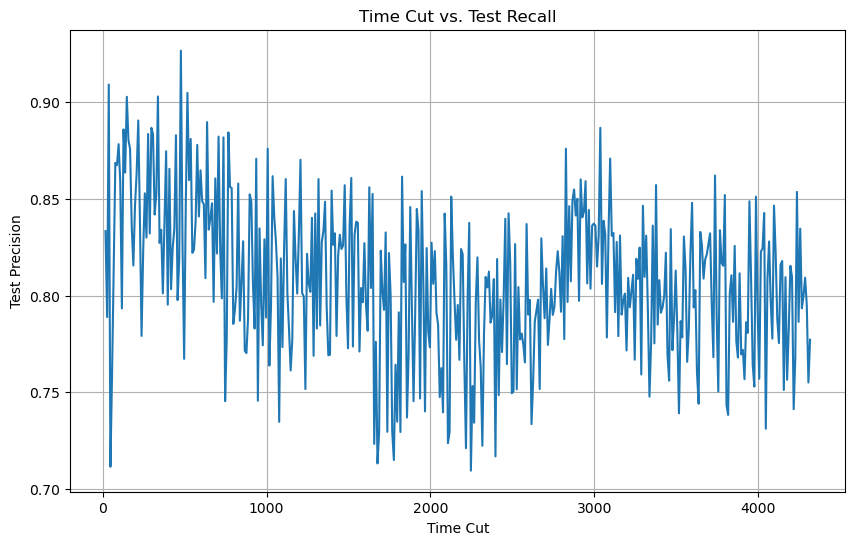

In [8]:

# Plotting time_cut vs. test_accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x='metrics.time_cut', y='metrics.test_recall', data=df)
plt.title('Time Cut vs. Test Recall')
plt.xlabel('Time Cut')
plt.ylabel('Test Precision')
plt.grid(True)
plt.show()

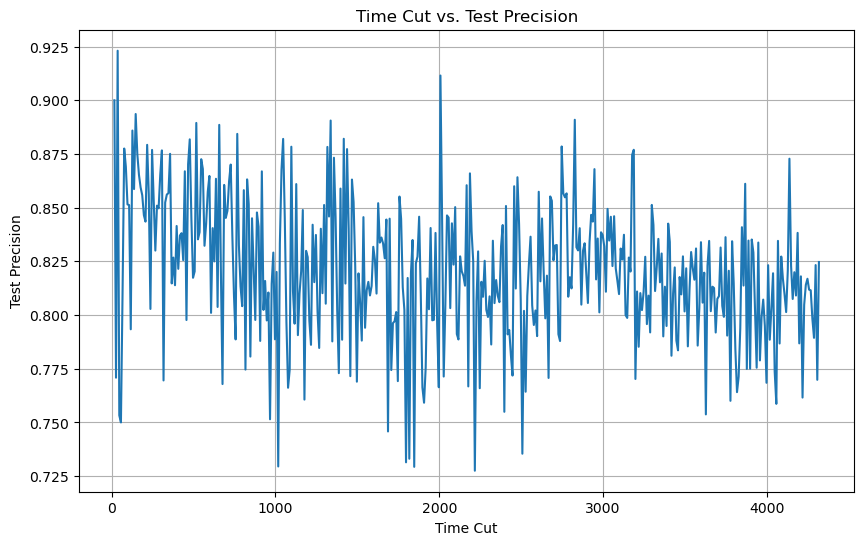

In [9]:

# Plotting time_cut vs. test_accuracy
plt.figure(figsize=(10, 6))S
sns.lineplot(x='metrics.time_cut', y='metrics.test_precision', data=df)
plt.title('Time Cut vs. Test Precision')
plt.xlabel('Time Cut')
plt.ylabel('Test Precision')
plt.grid(True)
plt.show()